In [43]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


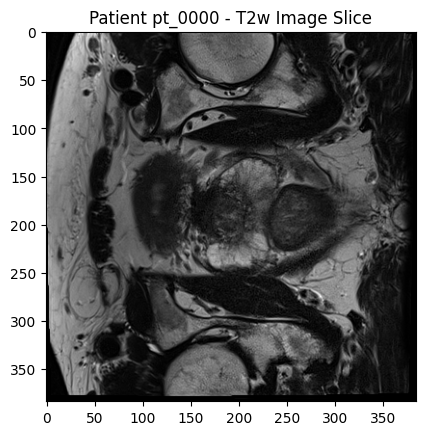

In [44]:
# Function to load NIfTI images for a patient
def load_nifti_images(patient_id, data_dir):
    t2w_file = os.path.join(data_dir, f'{patient_id}', 't2w.nii')
    adc_file = os.path.join(data_dir, f'{patient_id}', 'adc.nii')
    ktrans_file = os.path.join(data_dir, f'{patient_id}', 'ktrans.nii')

    t2w_img = nib.load(t2w_file).get_fdata()
    adc_img = nib.load(adc_file).get_fdata()
    ktrans_img = nib.load(ktrans_file).get_fdata()

    return t2w_img, adc_img, ktrans_img

patient_id = 'pt_0000'
data_dir = 'data/mri'
t2w_img, adc_img, ktrans_img = load_nifti_images(patient_id, data_dir)

plt.imshow(t2w_img[:, :, t2w_img.shape[2] // 2], cmap='gray')
plt.title(f'Patient {patient_id} - T2w Image Slice')
plt.show()


In [45]:
# Load labels from info.csv
csv_file = 'data/info.csv'
df = pd.read_csv(csv_file)

print(df.head())

df = df[['pt_id', 'ijk', 'label']]  


   index    pt_id Name  fid         ijk           Dim  label
0      1  pt_0000  t2w    1   167 224 9  384x384x19x1   True
1      2  pt_0001  t2w    1  157 186 10  384x384x19x1  False
2      3  pt_0002  t2w    2  203 216 10  384x384x19x1  False
3      4  pt_0002  t2w    1  154 217 12  384x384x19x1   True
4      5  pt_0003  t2w    1  240 205 12  384x384x21x1  False


In [51]:
def extract_finding_with_padding(ijk, img, target_size=32):
    i, j, k = [int(x) for x in ijk.split()]  
    
    half_size = target_size // 2

    # Extract sub-region around the finding
    extracted_img = img[max(i-half_size, 0):i+half_size, max(j-half_size, 0):j+half_size, max(k-half_size, 0):k+half_size]
    
    # Determine the actual shape of the extracted image
    actual_shape = extracted_img.shape

    # Padding each axis to reach the target size
    pad_x = target_size - actual_shape[0]
    pad_y = target_size - actual_shape[1]
    pad_z = target_size - actual_shape[2]
    
    # Apply padding
    padded_img = np.pad(extracted_img, 
                        ((0, pad_x), (0, pad_y), (0, pad_z)), 
                        mode='constant', constant_values=0)
    
    return padded_img

ijk = '50 60 40'  
finding_img = extract_finding_with_padding(ijk, t2w_img)

print(f'Shape of the padded finding: {finding_img.shape}')


Shape of the padded finding: (32, 32, 32)


In [52]:
print(len(finding_img))

32


In [50]:
findings_data = []
labels = []

for index, row in df.iterrows():
    patient_id = str(row['pt_id']).zfill(4)
    ijk = row['ijk']
    label = row['label']

    # Load MRI images
    t2w_img, adc_img, ktrans_img = load_nifti_images(patient_id, data_dir)
    
    t2w_finding = extract_finding_with_padding(ijk, t2w_img)
    adc_finding = extract_finding_with_padding(ijk, adc_img)
    ktrans_finding = extract_finding_with_padding(ijk, ktrans_img)

    # Stack the three images (T2w, ADC, Ktrans) into a 3D array
    finding_combined = np.stack([t2w_finding, adc_finding, ktrans_finding], axis=-1)
    
    findings_data.append(finding_combined)
    labels.append(label)

X = np.array(findings_data)
y = np.array(labels)

# Normalize the pixel values
X = X / np.max(X)

# Convert labels to binary
y = to_categorical(y)

# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')


Shape of X_train: (260, 32, 32, 32, 3)
Shape of y_train: (260, 2)


In [56]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

260
260
66
66


In [40]:
print(len(findings_data))  
print(len(findings_data[0]))  
print(len(findings_data[0][0]))  
print(len(findings_data[0][0][0]))


326
32
32
19
